# Setting up the environment #

The original image on this local machine is saved as "$img.png$".

&nbsp;


The first element of the first row of img_raw is:  [0.03529412 0.02352941 0.01568628]
The shape of img_raw is:  (2000, 1968, 3)


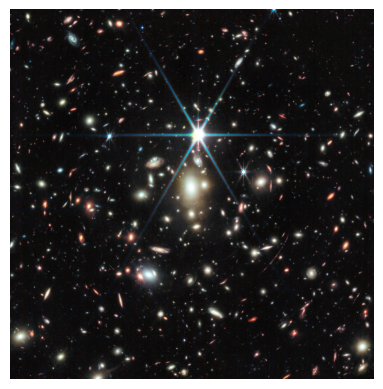

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import pandas as pd


#Loading the image

img_raw=plt.imread('img.png')

#print the first element of the first row of img_raw
print('The first element of the first row of img_raw is: ',img_raw[0,0])
print('The shape of img_raw is: ',img_raw.shape)
plt.imshow(img_raw)
#don't show the axes
plt.axis('off')
plt.show()

As we can see, the element at $(0,0)$ is not a scalar, rather a vector consisting of three componenets, namely the intensities of the Red, Green and Blue colour channels with values in the interval $[0,1]$. The $plt.imread()$ shows the intensities as floats in $[0,1]$, whereas some other module may show the pixel data as unsigned 8bit integers in $[0,255]$ (image depth 8bit). Here we proceed with the floating point representation, since SVD will be performed on the matrices and orthonormality is required for the column vectors of $U$ and $V$, there might be a significant loss of information while converting the floats of the $k-rank \ approximation$ to uint8.

The image is a 2000x1968x3 sized tensor, and we cannot directly apply SVD on the image itself. Therefore we intend to split this image into three channels and perform singular value decomposition on those respective channels and recombine the image to obtain a compressed version of the original image.

&nbsp;

In order to not repeatedly write the code for splitting and recombining the channels, we write a function that takes an image tensor of the form $m\times n \times 3$ and returns the intensities of the red, green and the blue channels in respective order in the form of $m\times n$ matrices.
We write another function that takes three matrices of the same size $m\times n$ as inputs in the same order as R,G,B and returns a tensor of the size $m\times n\times 3$.

&nbsp;

Additionally, we define another function that will come in handy from time to time. This function takes the intensity of a single colour channel as a matrix $M$ and a keyword $\alpha\in \{r,g,b\}$ as inputs and returns an image tensor that has only $M$ matrix on channel $\alpha$ and the rest of the colour intensities are set to 0. This will help us to see the image in three different colour modes when necessary. 

## Defining the RGB Splitting and Re-Combining Functions ##
&nbsp;

In [2]:
def split_rgb(image_tensor):
    #Split the image tensor into its red, green and blue components.
    red = image_tensor[:,:,0]
    green = image_tensor[:,:,1]
    blue = image_tensor[:,:,2]
    return red, green, blue

def combine_rgb(red, green, blue):
    #Combine the red, green and blue components to form a new image tensor.
    #axis=2 means that the stacking will be along the third dimension
    return np.stack((red, green, blue), axis=2) 


def single_channel_img(matrix,keyword:str):
    #create a blank image of size matrix.shape x 3
    #3 is for the three channels
    blank_image = np.zeros((matrix.shape[0],matrix.shape[1],3))
    img_new = blank_image.copy()
    if keyword=='r':
        #assign the red channel of the image to be matrix
        img_new[:,:,0]=matrix
    elif keyword=='g':
        #assign the green channel of the image to be matrix
        img_new[:,:,1]=matrix
    elif keyword=='b':
        #assign the blue channel of the image to be matrix
        img_new[:,:,2]=matrix
    else:
        print('Wrong keyword')
        return None
    return img_new


## Defining the Singular Value Decomposition and k-rank Approximation Functions ##
&nbsp;

In [3]:
def perform_svd(matrix):
        #Perform SVD on the input matrix and return the U, S and V^T matrices from the decomposition.
        U, S, VT = svd(matrix)
        return U, S, VT
        
def low_rank_approx(U,S,VT,k):
        #Perform low rank approximation of the input matrix using the first k singular values.
        #reconstruct the image using the first k singular values
        S = S[:k]
        U = U[:,:k]
        VT = VT[:k,:]
        return U@np.diag(S)@VT  # @ is matrix multiplication in numpy module

## Error Measurement ##
The following function takes two matrices $A$ and $B$ as inputs and returns the Frobenius and the 2-Norm of $(A-B)$ as a tuple.
&nbsp;

In [4]:
def error(A,B):
    #Compute the Frobenius and 2-norm error between the matrices A and B.
    return np.linalg.norm(A-B), np.linalg.norm(A-B,ord=2)

## The original image on three different channels ##
&nbsp;

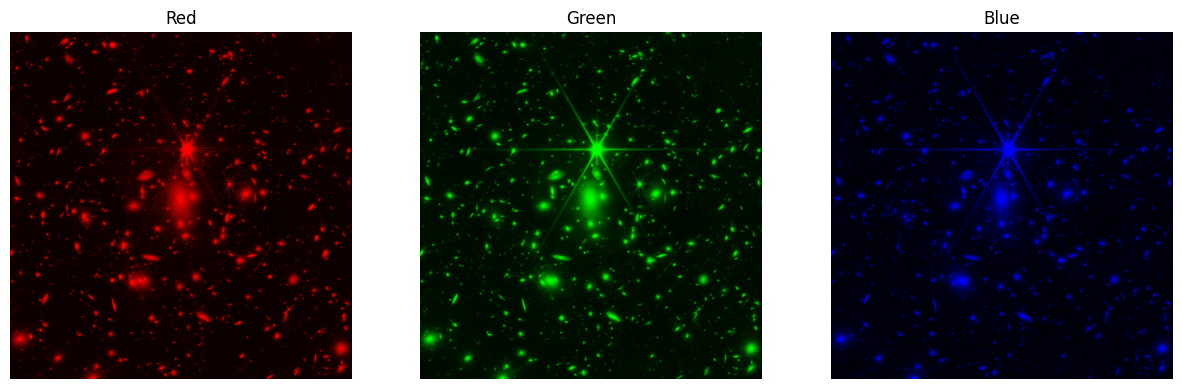

In [5]:
original_red, original_green, original_blue = split_rgb(img_raw)

fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(single_channel_img(original_red,'r'))
ax[0].axis('off')
ax[0].set_title('Red')
ax[1].imshow(single_channel_img(original_green,'g'))
ax[1].axis('off')
ax[1].set_title('Green')
ax[2].imshow(single_channel_img(original_blue,'b'))
ax[2].axis('off')
ax[2].set_title('Blue')
plt.show()

# Problem 2(a) & 2(c) #
&nbsp;

As per the problems, we first plot the singular values corresponding to the three channels to get a better idea regarding the minimum number of singular values required to make the compressed image almost indistinguishable from the original one.

## Plotting the singular values of R, G, B intensity matrices. ##
&nbsp;

In [6]:
#Perform SVD on the red channel
U_r, S_r, VT_r = perform_svd(original_red)
#Perform SVD on the green channel
U_g, S_g, VT_g = perform_svd(original_green)
#Perform SVD on the blue channel
U_b, S_b, VT_b = perform_svd(original_blue)

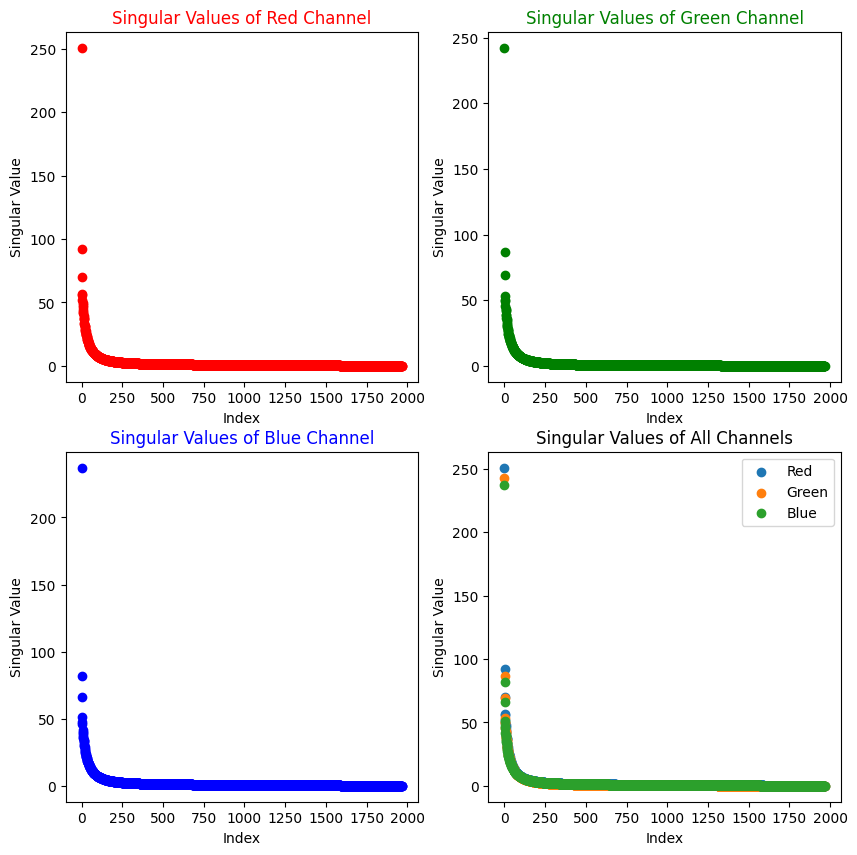

In [7]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(np.arange(len(S_r)),S_r,color='r')
ax[0,0].set_title('Singular Values of Red Channel',c='r')
ax[0,0].set_xlabel('Index')
ax[0,0].set_ylabel('Singular Value')
ax[0,0].set_xticks(np.arange(0,2250,250))
ax[0,1].scatter(np.arange(len(S_g)),S_g,color='g')
ax[0,1].set_title('Singular Values of Green Channel',c='g')
ax[0,1].set_xlabel('Index')
ax[0,1].set_ylabel('Singular Value')
ax[0,1].set_xticks(np.arange(0,2250,250))
ax[1,0].scatter(np.arange(len(S_b)),S_b,color='b')
ax[1,0].set_title('Singular Values of Blue Channel',c='b')
ax[1,0].set_xlabel('Index')
ax[1,0].set_ylabel('Singular Value')
ax[1,0].set_xticks(np.arange(0,2250,250))
ax[1,1].scatter(np.arange(len(S_r)),S_r,label='Red')
ax[1,1].scatter(np.arange(len(S_g)),S_g,label='Green')
ax[1,1].scatter(np.arange(len(S_b)),S_b,label='Blue')
ax[1,1].set_title('Singular Values of All Channels')
ax[1,1].set_xlabel('Index')
ax[1,1].set_ylabel('Singular Value')
ax[1,1].set_xticks(np.arange(0,2250,250))
ax[1,1].legend()
plt.show()

&nbsp;
As we can observe from the plots, most of the "energy" of all the three matrices are being captured within the first 250 of the singular values. Before we proceed to approximate the image corresponding to different approximations, we plot the cumulative $\%$ plot for the information captured. $\sum_i \sigma_i^2$ is the total energy captured by the matrices.
&nbsp;

The first 250 cumulative energy of the red channel is:  98.89116
The first 500 cumulative energy of the red channel is:  99.51962


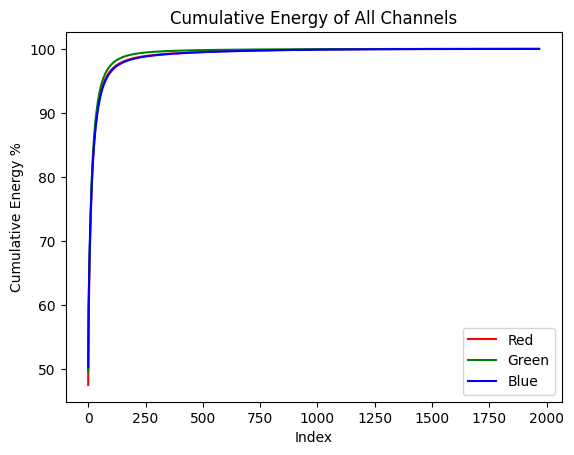

In [8]:
#cumulative percentage of the total energy contained
#squaring the singular values for the energy captured

cumulative_energy_r = np.cumsum(S_r**2)/np.sum(S_r**2)*100
cumulative_energy_g = np.cumsum(S_g**2)/np.sum(S_g**2)*100
cumulative_energy_b = np.cumsum(S_b**2)/np.sum(S_b**2)*100

print('The first 250 cumulative energy of the red channel is: ',cumulative_energy_r[250])
print('The first 500 cumulative energy of the red channel is: ',cumulative_energy_r[500])
plt.figsize=(10,10)
plt.plot(np.arange(len(cumulative_energy_r)),cumulative_energy_r,color='r',label='Red')
plt.plot(np.arange(len(cumulative_energy_g)),cumulative_energy_g,color='g',label='Green')
plt.plot(np.arange(len(cumulative_energy_b)),cumulative_energy_b,color='b',label='Blue')
plt.title('Cumulative Energy of All Channels')
plt.xlabel('Index')
plt.ylabel('Cumulative Energy %')
plt.xticks(np.arange(0,2250,250))
plt.legend()
plt.show()


## Images for different $k$-rank approximations ##

### Defining a helper function $image\_approx$ ###
&nbsp;
This function uses the decomposition of the matrices $r$, $g$, $b$ and takes $k$ as an input to do the following:

1. Obtain the k-rank approximation of the matrices

2. If an entry $\gamma$ in the approximated channel is $\gamma <0$, set $\gamma=0$, if $\gamma>1$, set $\gamma=1$.

3. Combine the three approximations into tensor of the same size as the original image. 

4. Frobenius error, 2-Norm error, $(k+1)$ th singular value (ideal 2-norm), $\sqrt{\sum_{k+1}^{1968}\sigma_i^2}$ (ideal Frobenius norm) alongside the total entries sent back to earth is recorded as a row in a dataframe. We record the comparisons twice, before and after chopping off the illegal values.

    **Note**: In the code, we need to shift the indices by $-1$, as the indexing starts from $0$, i.e the $(k+1)$ th singular value has the index $k$ in the array.

5. Return the compressed image and the dataframes (before and after).

For approximating the image with the first $k$ singular values, we get back $k(1928+2000+1)$ entries each for $R,G,B$. The reasoning is that we send back the first $k$ columns of the matrix $V^T$, so $1968k$ entries, the first $k$ singular values and the first $k$ columns of the matrix $U$, i.e $2000k$ entries. Therefore one needs to send a total of $3k(1968+2000+1)$ entries to Earth, combining all the channels.

&nbsp; 

In [9]:
r=split_rgb(img_raw)[0]
g=split_rgb(img_raw)[1]
b=split_rgb(img_raw)[2]

U_r, S_r, VT_r = perform_svd(r)
U_g, S_g, VT_g = perform_svd(g)
U_b, S_b, VT_b = perform_svd(b)


def image_approx(k):
    r_new = low_rank_approx(U_r,S_r,VT_r,k)
    g_new = low_rank_approx(U_g,S_g,VT_g,k)
    b_new = low_rank_approx(U_b,S_b,VT_b,k)

    ### k+1 th singular value has the index k ###
    # Measuring the error before clipping the values of the matrices to be between 0 and 1.

    r_errors_before_clipping = error(r,r_new), np.sqrt(np.sum(S_r[k:]**2)), S_r[k]
    g_errors_before_clipping = error(g,g_new), np.sqrt(np.sum(S_g[k:]**2)), S_g[k]
    b_errors_before_clipping = error(b,b_new), np.sqrt(np.sum(S_b[k:]**2)), S_b[k]

    r_new=np.clip(r_new,0,1)
    g_new=np.clip(g_new,0,1)
    b_new=np.clip(b_new,0,1)
    
    #ideal Frobenius norm error is np.sqrt(np.sum(S_r[k:]**2))
    #ideal 2-norm error is S_r[k]


    ### k+1 th singular value has the index k ###
    # Measuring the error after clipping the values of the matrices to be between 0 and 1.

    r_errors_after_clipping = error(r,r_new), np.sqrt(np.sum(S_r[k:]**2)), S_r[k]
    g_errors_after_clipping = error(g,g_new), np.sqrt(np.sum(S_g[k:]**2)), S_g[k]
    b_errors_after_clipping = error(b,b_new), np.sqrt(np.sum(S_b[k:]**2)), S_b[k]

    
    

    compressed_img = combine_rgb(r_new,g_new,b_new)

    #read the size of the compressed image
    
    entries=k*(r.shape[0]+r.shape[1]+1)+k*(g.shape[0]+g.shape[1]+1)+k*(b.shape[0]+b.shape[1]+1)

    error_data_before_clipping=pd.DataFrame({
        'k':[k], 'Frobenius Error (R)': [r_errors_before_clipping[0][0]], 'Ideal Frobenius Error (R)': [r_errors_before_clipping[1]], '2-norm Error (R)': [r_errors_before_clipping[0][1]], 'Ideal 2-norm Error (R)': [r_errors_before_clipping[2]],
        'Frobenius Error (G)': [g_errors_before_clipping[0][0]], 'Ideal Frobenius Error (G)': [g_errors_before_clipping[1]], '2-norm Error (G)': [g_errors_before_clipping[0][1]], 'Ideal 2-norm Error (G)': [g_errors_before_clipping[2]],
        'Frobenius Error (B)': [b_errors_before_clipping[0][0]], 'Ideal Frobenius Error (B)': [b_errors_before_clipping[1]], '2-norm Error (B)': [b_errors_before_clipping[0][1]], 'Ideal 2-norm Error (B)': [b_errors_before_clipping[2]],
    })

    error_data_after_clipping=pd.DataFrame({
        'k':[k], 'Frobenius Error (R)': [r_errors_after_clipping[0][0]], 'Ideal Frobenius Error (R)': [r_errors_after_clipping[1]], '2-norm Error (R)': [r_errors_after_clipping[0][1]], 'Ideal 2-norm Error (R)': [r_errors_after_clipping[2]],
        'Frobenius Error (G)': [g_errors_after_clipping[0][0]], 'Ideal Frobenius Error (G)': [g_errors_after_clipping[1]], '2-norm Error (G)': [g_errors_after_clipping[0][1]], 'Ideal 2-norm Error (G)': [g_errors_after_clipping[2]],
        'Frobenius Error (B)': [b_errors_after_clipping[0][0]], 'Ideal Frobenius Error (B)': [b_errors_after_clipping[1]], '2-norm Error (B)': [b_errors_after_clipping[0][1]], 'Ideal 2-norm Error (B)': [b_errors_after_clipping[2]],
        'Entries Sent': [entries]
    })

    return compressed_img, error_data_before_clipping, error_data_after_clipping

### Images obtained for different $k$. ###
&nbsp;

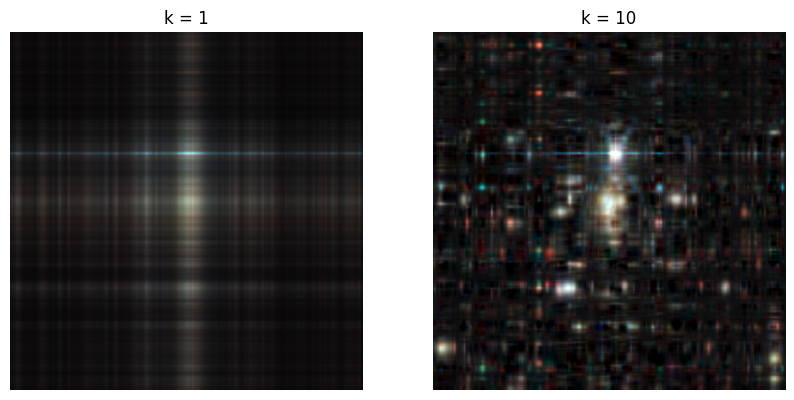

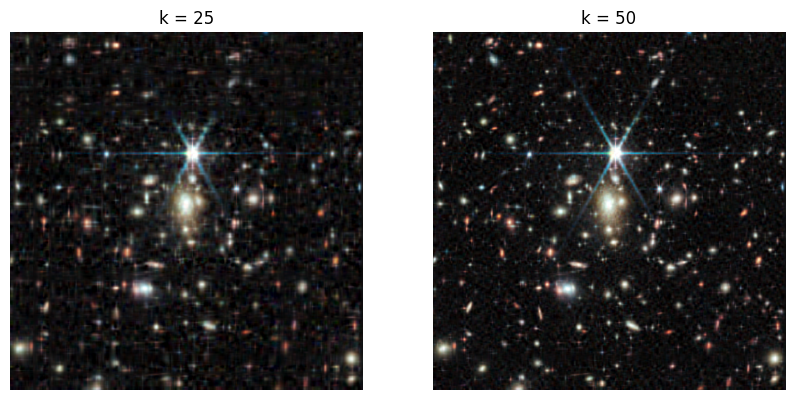

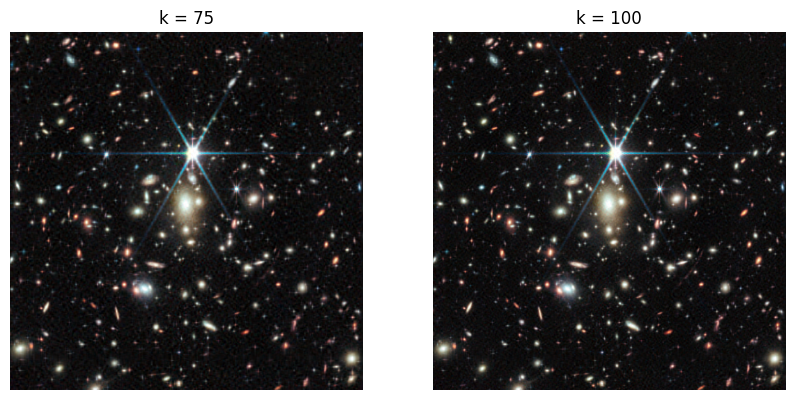

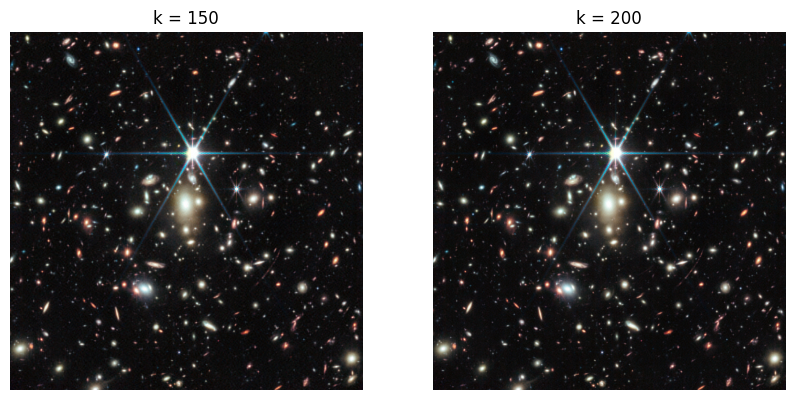

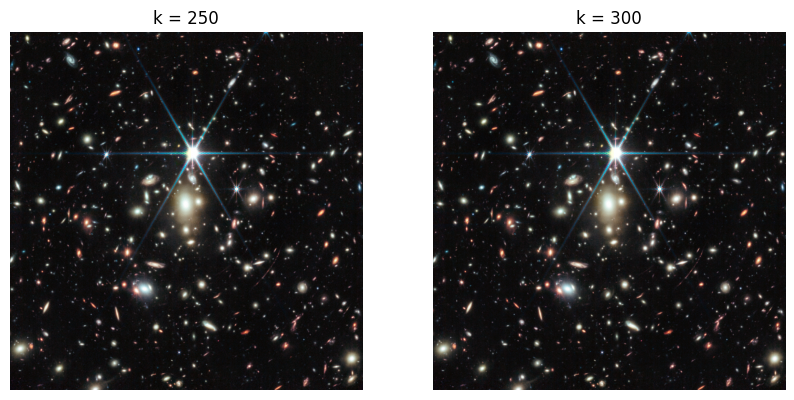

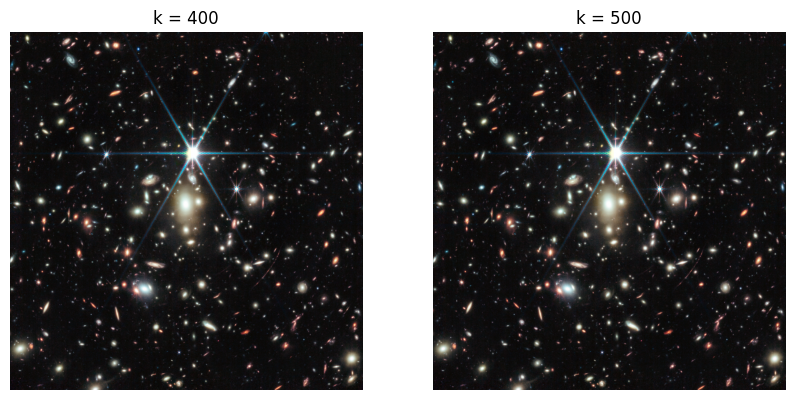

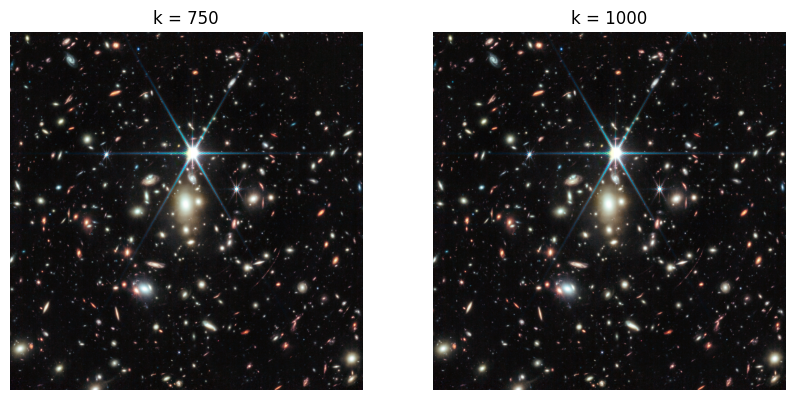

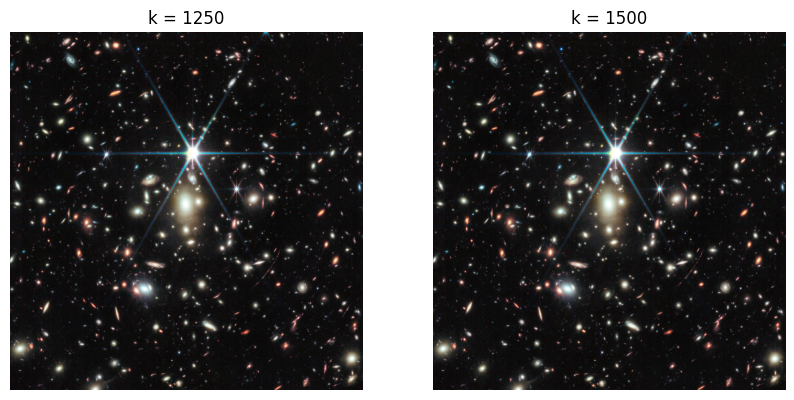

In [10]:
error_df_after_clip=pd.DataFrame(columns=['k','Frobenius Error (R)','Ideal Frobenius Error (R)','2-norm Error (R)','Ideal 2-norm Error (R)',
                                 'Frobenius Error (G)','Ideal Frobenius Error (G)','2-norm Error (G)','Ideal 2-norm Error (G)',
                                 'Frobenius Error (B)','Ideal Frobenius Error (B)','2-norm Error (B)','Ideal 2-norm Error (B)','Entries Sent'])

error_df_before_clip=pd.DataFrame(columns=['k','Frobenius Error (R)','Ideal Frobenius Error (R)','2-norm Error (R)','Ideal 2-norm Error (R)',
                                    'Frobenius Error (G)','Ideal Frobenius Error (G)','2-norm Error (G)','Ideal 2-norm Error (G)',
                                    'Frobenius Error (B)','Ideal Frobenius Error (B)','2-norm Error (B)','Ideal 2-norm Error (B)'])


list_k=[1,10,25,50,75,100,150,200,250,300,400,500,750,1000,1250,1500]

for i in range(int(len(list_k)/2)):
    compressed_img1,error_data1_before ,error_data1_after = image_approx(list_k[2*i])
    compressed_img2,error_data2_before ,error_data2_after = image_approx(list_k[2*i+1])
    error_df_after_clip=pd.concat([error_df_after_clip,error_data1_after,error_data2_after],ignore_index=True)
    error_df_before_clip=pd.concat([error_df_before_clip,error_data1_before,error_data2_before],ignore_index=True)
    
    fig, ax = plt.subplots(1,2,figsize=(10,10))
    ax[0].imshow(compressed_img1)
    ax[0].axis('off')
    ax[0].set_title('k = '+str(list_k[2*i]))
    ax[1].imshow(compressed_img2)
    ax[1].axis('off')
    ax[1].set_title('k = '+str(list_k[2*i+1]))
    plt.show()


error_df_before_clip.to_csv('error_data_before_clip.csv',index=False) #saving the prior error data to a csv file
error_df_after_clip.to_csv('error_data_after_clip.csv',index=False) #saving the posterior error data to a csv file


    

&nbsp;
The following table contains the errors and the entries sent for different values of $k$. Following are the abbreviations used in the header:

* $FE \ (c):=$ Frobenius Error in channel $c$

* $IFE \ (c):=$ Ideal Frobenius Error in channel $c$

* $2E \ (c):=$ 2-norm Error in channel $c$

* $I2E \ (c):=$ Ideal 2-norm Error in channel $c$


In [13]:
dataframe1=pd.read_csv('error_data_before_clip.csv')
dataframe2=pd.read_csv('error_data_after_clip.csv')


In [16]:
dataframe1.style.set_caption('Error Data Before Clipping')

In [17]:
dataframe2.style.set_caption('Error Data After Clipping')



From the first table, it's evident that the theorem holds empirically as well. The slight mismatches are due to round-off errors.

In the second table, the differences are larger due to the matrices being modified to only contain values in $[0,1]$.

# Problem 2(b) #

&nbsp;
Visually, there seems to be almost no difference between $k=100$ and the original image. For $k=75$ the image seems a bit blurry. We now check out the energy captured by our different choices of $k$ and the $\%$ of amount of entries that we need to send as compared to the original $2000\times1968\times3=11808000$ entries.
&nbsp;

In [11]:
No_entries=2000*1968*3
k_list=[75,100,150,200,250,300,400,500]
for i in k_list:
    print('Cumulative energy for RGB with k=',i,': ',cumulative_energy_r[i],cumulative_energy_g[i],cumulative_energy_b[i])
    print('% of entries required for k=',i,': ', round(error_df_after_clip[error_df_after_clip['k']==i]['Entries Sent'].values[0]/No_entries*100,2))

Cumulative energy for RGB with k= 75 :  95.30186 96.1799 95.0098
% of entries required for k= 75 :  7.56
Cumulative energy for RGB with k= 100 :  96.706024 97.5227 96.48528
% of entries required for k= 100 :  10.08
Cumulative energy for RGB with k= 150 :  97.99125 98.709236 97.85228
% of entries required for k= 150 :  15.13
Cumulative energy for RGB with k= 200 :  98.56814 99.19838 98.468834
% of entries required for k= 200 :  20.17
Cumulative energy for RGB with k= 250 :  98.89116 99.44199 98.81307
% of entries required for k= 250 :  25.21
Cumulative energy for RGB with k= 300 :  99.0966 99.58121 99.034515
% of entries required for k= 300 :  30.25
Cumulative energy for RGB with k= 400 :  99.3541 99.733765 99.315765
% of entries required for k= 400 :  40.34
Cumulative energy for RGB with k= 500 :  99.51962 99.81431 99.493286
% of entries required for k= 500 :  50.42


Depending on the constraints on board, if high compression is required while preserving more than $96\%$ of the details, one can select $k=100$. This achieves $\approx 90\%$ compression. 

If $99\%$ of the details is a bare minimum, $k=300$ can be selected, which still achieves around $70\%$ compression. Going beyond this seems like an overkill, which worsens compression and it adds almost nothing to the details. 

Taking a value in-between the two, $k=200$ would be my personal choice, as it maintains $98\%$ of the original data and around $80\%$ reduction is achieved.

